In [1]:
%matplotlib inline
from model import num_infected

from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.distributions import constraints

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

pyro.set_rng_seed(101)

In [2]:
conditioned_individual = pyro.condition(num_infected, data={'protocol': torch.tensor(1.0)})

def parametrized_guide_constrained():
    rate_contacted = pyro.param('rate_contacted', torch.tensor(10.), constraint=constraints.positive)
    contacted_people = pyro.sample('contacted_people', pyro.distributions.Poisson(rate_contacted))
    
    infection_conc_0 = pyro.param('infection_conc_0', torch.tensor(15.0), constraint=constraints.positive)
    infection_conc_1 = pyro.param('infection_conc_1', torch.tensor(15.0), constraint=constraints.positive)
    infection_rate = pyro.sample('infection_rate', pyro.distributions.Beta(infection_conc_1, infection_conc_0))

    rate_num_infected = contacted_people * infection_rate
    num_infected = pyro.sample('num_infected', pyro.distributions.Poisson(rate_num_infected))

rate_contacted:  101.93775939941406
infection_conc_0:  26.733762741088867
infection_conc_1:  7.049495697021484


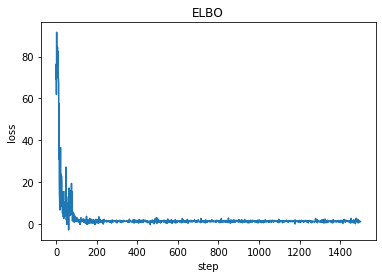

In [3]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_individual,
                     guide=parametrized_guide_constrained,
                     optim=pyro.optim.SGD({"lr": 0.001, "momentum":0.1}),
                     loss=pyro.infer.Trace_ELBO())


losses, rate_contacted, infection_conc_0, infection_conc_1  = [], [], [], []
num_steps = 1500
for t in range(num_steps):
    losses.append(svi.step())
    rate_contacted.append(pyro.param('rate_contacted').item())
    infection_conc_0.append(pyro.param('infection_conc_0').item())
    infection_conc_1.append(pyro.param('infection_conc_1').item())
    

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('rate_contacted: ',pyro.param('rate_contacted').item())
print('infection_conc_0: ',pyro.param('infection_conc_0').item())
print('infection_conc_1: ',pyro.param('infection_conc_1').item())

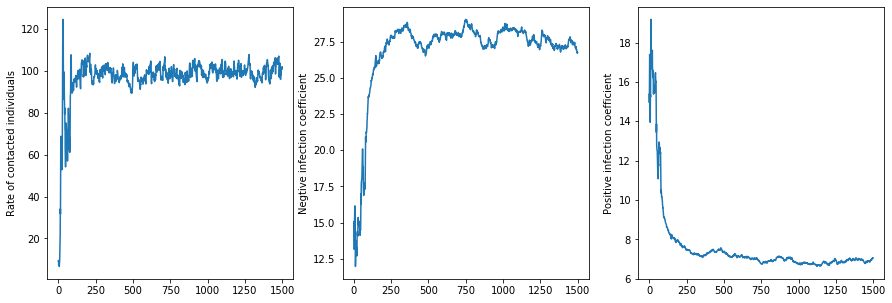

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

axs[0].set_ylabel('Rate of contacted individuals')
axs[0].plot(rate_contacted)

axs[1].set_ylabel('Negtive infection coefficient')
axs[1].plot(infection_conc_0)

axs[2].set_ylabel('Positive infection coefficient')
axs[2].plot(infection_conc_1)